# VITALS Tutorial 1

## Part A: Finding Conccurent Data

### Part 1: Data Setup and Dependencies

Create a working environment with required packages. Be sure to active your environment and choose the right kernel each time you work on your project.

In [1]:
#Run in Terminal: mamba create -n (environmentname) -c conda-forge --yes python=3.12 gdal fiona hvplot geoviews rioxarray rasterio jupyter geopandas earthaccess jupyter_bokeh h5py h5netcdf spectral scikit-image jupyterlab seaborn dask ray-default pystac-client odc-stac pyresample libgdal-hdf4 harmony-py

# Import required libraries
import os
import json
import folium
import earthaccess
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs

from branca.element import Figure
from shapely.geometry import MultiPolygon, Polygon, box
from shapely.geometry.polygon import orient
from datetime import timedelta
from earthaccess import DataGranules


### Part 2: NASA Earthdata Authentication

To access data from NASA Earthdata, you must first authenticate using the earthaccess library. Follow the interactive login prompt that appears to sign in with your NASA Earthdata credentials (email and password associated with your Earthdata account). This step ensures you have authorized access to download and search Earth observation datasets.

If you haven’t registered yet, create a free account here: https://urs.earthdata.nasa.gov/users/new

In [2]:
# Authenticate earthaccess
auth = earthaccess.Auth()
auth.login(strategy="interactive", persist=True)
print('Authenticated:', auth.authenticated)

Authenticated: True


### Part 3: Loading in situ Data

In order to analyze field sites, in situ data must be loaded in. Replace the file names with your own geojson in situ file. If only remote sensing practices will be used, commment out this code.

   id                                           geometry
0   1  MULTIPOLYGON (((-117.87121 33.591, -117.86482 ...
   id                                           geometry
0   2  MULTIPOLYGON (((-117.25996 32.72822, -117.2543...
   id                                           geometry
0   3  MULTIPOLYGON (((-118.42286 33.76332, -118.4140...


<Axes: >

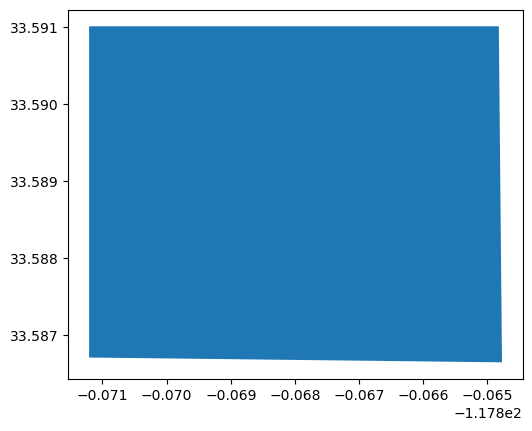

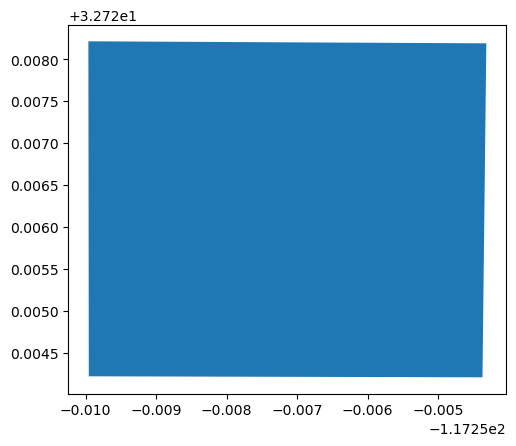

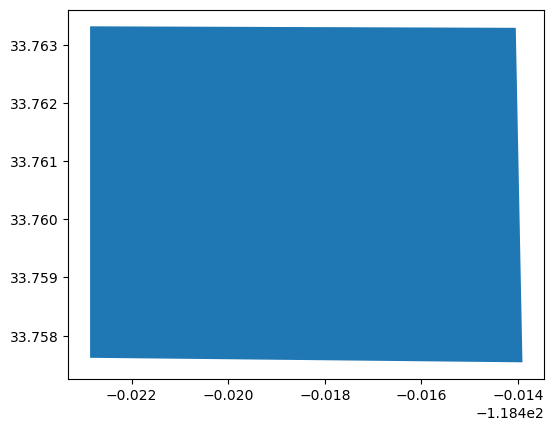

In [3]:
#Define Region(s) of Interest for ECOSTRESS and EMIT Requests. 
#gpd reads spatial data from various file formats and loads it into a GeoDataFrame object
%matplotlib inline
LCDMPolygon = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMPolygon.geojson")
SDPolygon = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/SDPolygon.geojson")
PVPolygon = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/PVPolygon.geojson")

print(LCDMPolygon.head()) #Prints the first few attributes of the read files.
print(SDPolygon.head())
print(PVPolygon.head())

LCDMPolygon.plot() #not necessary to plot. The plot will show the boundaries of you POI for ECOSTRESS and EMIT concurrent data. 
SDPolygon.plot()
PVPolygon.plot()

#Comment out to check CRS
# LCDMPolygon.crs
# SDPolygon.crs
# PVPolygon.crs

#### Part 3a: Visualizing Sample Locations

It is helpful to validate whether your data was loaded in properly. Visualizing your AOI will also assist in analysis. You can either view this as a plot or through an interactive map.

       filename   latitude   longitude  Dist_Coast  Transect#  Quadrat#  \
0  IMG_2404.JPG  33.589467 -117.868247           0          1         1   
1  IMG_2405.JPG  33.589403 -117.868331          10          1         2   
2  IMG_2406.JPG  33.589353 -117.868414          20          1         3   
3  IMG_2407.JPG  33.589294 -117.868492          30          1         4   
4  IMG_2408.JPG  33.589247 -117.868592          40          1         5   

                      geometry  
0  POINT (-117.86825 33.58947)  
1   POINT (-117.86833 33.5894)  
2  POINT (-117.86841 33.58935)  
3  POINT (-117.86849 33.58929)  
4  POINT (-117.86859 33.58925)  
       filename   latitude   longitude  Dist_coast  Transect#  Quadrat#  \
0  IMG_8100.JPG  32.725650 -117.257706           0          1         1   
1  IMG_8101.JPG  32.725681 -117.257814          10          1         2   
2  IMG_8102.JPG  32.725758 -117.257897          20          1         3   
3  IMG_8104.JPG  32.725711 -117.257606           0 

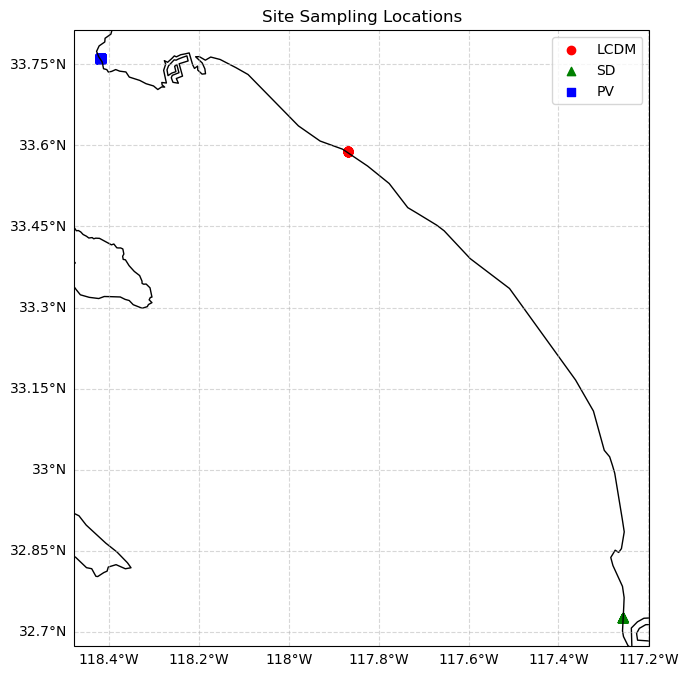

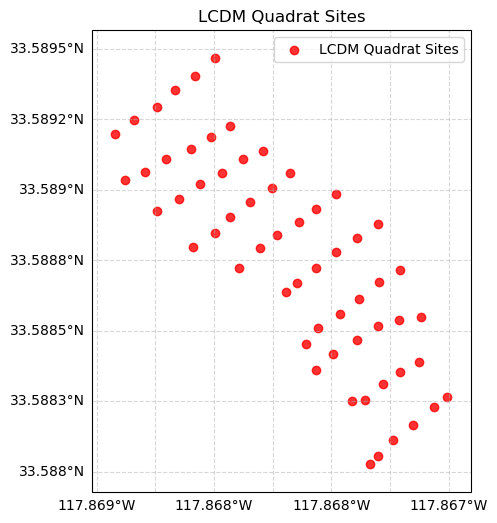

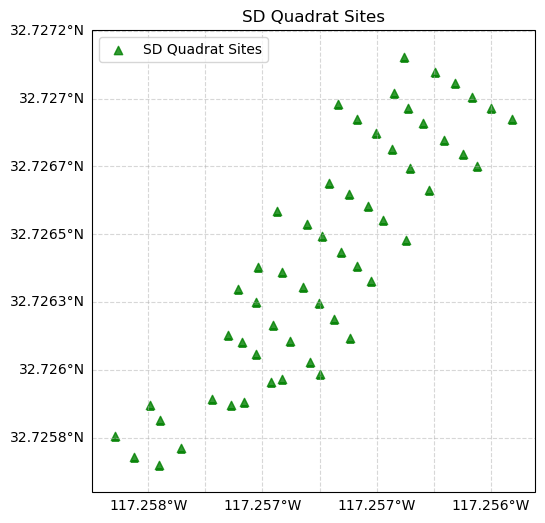

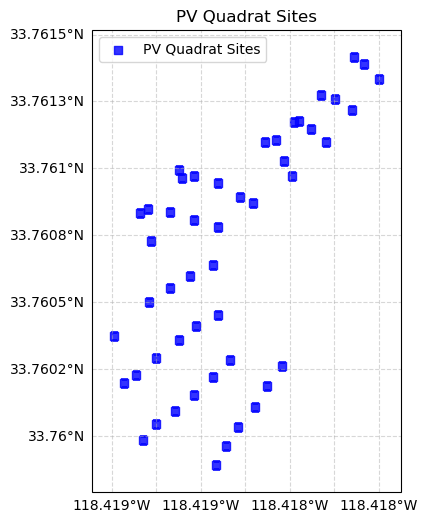

In [4]:
#Visualize Sample Locations on a Plot.
# Load GeoJSON files
LCDMQuadrat = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMQuadrat.geojson")
SDQuadrat = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/SDQuadrat.geojson")
PVQuadrat = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/PVQuadrat.geojson")

print(LCDMQuadrat.head())
print(SDQuadrat.head())
print(PVQuadrat.head())

# Set up the plot with Cartopy for mapping
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Add high-resolution coastlines and gridlines
ax.coastlines(resolution='10m')
gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)
gl.top_labels = gl.right_labels = False

# Plot the GeoDataFrames
LCDMQuadrat.plot(ax=ax, marker='o', color='red', label='LCDM', transform=ccrs.PlateCarree())
SDQuadrat.plot(ax=ax, marker='^', color='green', label='SD', transform=ccrs.PlateCarree())
PVQuadrat.plot(ax=ax, marker='s', color='blue', label='PV', transform=ccrs.PlateCarree())

plt.legend()
plt.title("Site Sampling Locations")
plt.show()


# Visualize all locations within one grid.
def plot_quadrats(gdf, title, color, marker):
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    
    ax.coastlines(resolution='10m')    # Plot coastlines
    gl = ax.gridlines(draw_labels=True, linestyle='--', alpha=0.5)     # Gridlines
    gl.top_labels = gl.right_labels = False
    gdf.plot(ax=ax, color=color, marker=marker, alpha=0.8, transform=ccrs.PlateCarree(), label=title)     # Plot quadrats

    # Auto-zoom to the bounds of the GeoDataFrame (pad for clarity)
    minx, miny, maxx, maxy = gdf.total_bounds
    padding = 0.0001 # degree buffer
    ax.set_extent([minx - padding, maxx + padding, miny - padding, maxy + padding], crs=ccrs.PlateCarree())

    # Title and legend
    plt.title(title)
    plt.legend()
    plt.show()


# Visualize each location separately
#Coasts will not be visible due to space constraints.
plot_quadrats(LCDMQuadrat, "LCDM Quadrat Sites", "red", "o") 
plot_quadrats(SDQuadrat,   "SD Quadrat Sites",   "green", "^")
plot_quadrats(PVQuadrat,   "PV Quadrat Sites",   "blue", "s")


In [5]:
#Visualize Sample Locations on an Interactive Map.

# Load all 3 ROI polygon GeoJSONs
LCDMpolygon = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMPolygon.geojson")
SDpolygon   = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/SDPolygon.geojson")
PVpolygon   = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/PVPolygon.geojson")

#Load points within locations
LCDM_points = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMQuadrat.geojson")
SD_points   = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/SDQuadrat.geojson")
PV_points   = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/PVQuadrat.geojson")


# Combine to get a universal bounding box
combined = gpd.GeoDataFrame(pd.concat([LCDMpolygon, SDpolygon, PVpolygon], ignore_index=True), crs=LCDMpolygon.crs)
bbox = combined.total_bounds  # [minx, miny, maxx, maxy]
agu_bbox = gpd.GeoDataFrame(geometry=[combined.unary_union.envelope], crs=combined.crs)

# Create interactive map using folium and Google Satellite basemap
fig_roi = Figure(width="750px", height="375px")
map_roi = folium.Map(
    tiles='https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}', 
    attr='Google Satellite', 
    name='Google Satellite'
)
fig_roi.add_child(map_roi)

# Add bounding box layer
folium.GeoJson(
    agu_bbox,
    name='Bounding Box'
).add_to(map_roi)

# Add all 3 polygons to the map with different colors
LCDMpolygon.explore(
    m=map_roi,
    name="LCDM",
    column=None,
    style_kwds=dict(color="red", fillOpacity=0.1, weight=10),
    popup=True
)

SDpolygon.explore(
    m=map_roi,
    name="SD",
    column=None,
    style_kwds=dict(color="green", fillOpacity=0.1, weight=10),
    popup=True
)

PVpolygon.explore(
    m=map_roi,
    name="PV",
    column=None,
    style_kwds=dict(color="blue", fillOpacity=0.1, weight=10),
    popup=True
)

# Add LCDM points
for _, row in LCDM_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color="red",
        fill=True,
        fill_color="red",
        popup=row.get("name", "LCDM Point")
    ).add_to(map_roi)

# Add SD points
for _, row in SD_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color="green",
        fill=True,
        fill_color="green",
        popup=row.get("name", "SD Point")
    ).add_to(map_roi)

# Add PV points
for _, row in PV_points.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=5,
        color="blue",
        fill=True,
        fill_color="blue",
        popup=row.get("name", "PV Point")
    ).add_to(map_roi)



# Add layer control toggle
map_roi.add_child(folium.LayerControl())

# Fit map bounds to the union of all 3 polygons
minx, miny, maxx, maxy = combined.total_bounds
map_roi.fit_bounds(bounds=((miny, minx), (maxy, maxx)))

# Show map
fig_roi


/var/folders/p1/510x9_195sb_k_0vw8ll_qyw0000gn/T/ipykernel_3996/3685010661.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  agu_bbox = gpd.GeoDataFrame(geometry=[combined.unary_union.envelope], crs=combined.crs)


### Part 4: Accessing and Utilizing ECOSTRESS and EMIT Data

The next step is to match in situ data to the corresponding satellite observations from ECOSTRESS and EMIT. The code below is to collect concurrent ECOSTRESS and EMIT data for Little Corona Del Mar, Newport Beach.The granules that are found for the site will be printed for this code.

In [6]:
#Uncomment this code to use separate ECOSTRESS and EMIT data. 
# import earthaccess
# import geopandas as gpd

# lcdm_poly = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMPolygon.geojson") #change the file path based on the location. 
# minx, miny, maxx, maxy = lcdm_poly.total_bounds  # xmin, ymin, xmax, ymax

# # Expand bounding box by 0.05 degrees (approx ~5-6km) Remove comment if needed. 
# # buffer_deg = 0.05
# # minx, miny, maxx, maxy = lcdm_poly.total_bounds
# # minx -= buffer_deg
# # miny -= buffer_deg
# # maxx += buffer_deg
# # maxy += buffer_deg

# #Set time window
# start_date = "2024-05-01"
# end_date = "2025-05-31"

# # Search ECOSTRESS granules
# ecostress_granules = earthaccess.search_data(
#     short_name="ECO_L2T_LSTE",
#     cloud_hosted=True,
#     temporal=(start_date, end_date),
#     bounding_box=(minx, miny, maxx, maxy)
# )

# # Search EMIT granules
# emit_granules = earthaccess.search_data(
#     short_name="EMITL2ARFL",
#     cloud_hosted=True,
#     temporal=(start_date, end_date),
#     bounding_box=(minx, miny, maxx, maxy)
# )

# print(f"ECOSTRESS granules found: {len(ecostress_granules)}")
# print(f"EMIT granules found: {len(emit_granules)}")


In [8]:
#This code searches ET/EMIT at the same time
# Load region of interest (LCDM polygon)
PointofInterest = gpd.read_file("/Users/kylamonique/Desktop/JPLFiles/SpectralEvolution/GIS/Waypoints/LCDMQuadrat.geojson")
roi_polygon = PointofInterest.geometry.union_all().convex_hull
minx, miny, maxx, maxy = PointofInterest.total_bounds

# ECOSTRESS Collection Query
eco_collection_query = earthaccess.collection_query().keyword('ECOSTRESS L2 Tiled LSTE')
eco_collection_query.fields(['ShortName','EntryTitle','Version']).get()

# EMIT Collection Query
emit_collection_query = earthaccess.collection_query().keyword('EMIT L2A Reflectance')
emit_collection_query.fields(['ShortName','EntryTitle','Version']).get()

# Define time range
start_date = "2024-05-01"
end_date = "2025-05-31"
date_range = (start_date, end_date)

# Define concept IDs for EMIT + ECOSTRESS tiled products
concept_ids = [
    "C2408750690-LPCLOUD",  # EMIT L2A Reflectance Tiled
    "C2076090826-LPCLOUD"   # ECOSTRESS L2T LST/Emissivity Tiled
]

# Combined search using both concept IDs
granuleresults = earthaccess.search_data(
    concept_id=concept_ids,
    bounding_box=(minx, miny, maxx, maxy),
    temporal=date_range,
    cloud_hosted=True
)

# Separate EMIT and ECOSTRESS by ShortName
emit_granules = [g for g in granuleresults if g["umm"]["CollectionReference"]["ShortName"] == "EMITL2ARFL"]
ecostress_granules = [g for g in granuleresults if g["umm"]["CollectionReference"]["ShortName"] == "ECO_L2T_LSTE"]

output_file = '/Users/kylamonique/Desktop/JPLFiles/PythonCode/required_granules.txt'

 # Define desired asset patterns
desired_ecostress_assets = ['_LST.tif', '_QC.tif', '_cloud.tif']
desired_emit_extensions = ['.nc']

with open(output_file, 'w') as f:
    # Filter ECOSTRESS
    for granule in ecostress_granules:
        for link in granule.data_links(access="https"):
            filename = link.split("/")[-1]
            if any(filename.endswith(tag) for tag in desired_ecostress_assets):
                f.write(link + '\n')

    # Filter EMIT
    for granule in emit_granules:
        for link in granule.data_links(access="https"):
            filename = link.split("/")[-1]
            if any(filename.endswith(ext) for ext in desired_emit_extensions):
                f.write(link + '\n')


print("✅ Granule links saved to required_granules.txt")


# Print counts
print(f"Total granules found: {len(granuleresults)}")
print(f"Total EMIT granules found: {len(emit_granules)}")
print(f"Total ECOSTRESS granules found: {len(ecostress_granules)}")

✅ Granule links saved to required_granules.txt
Total granules found: 229
Total EMIT granules found: 11
Total ECOSTRESS granules found: 218


In [9]:
#Check if only relevant data will be downloaded. 
with open(output_file) as f:
    lines = f.readlines()
print(f"Filtered lines in required_granules.txt: {len(lines)}")

Filtered lines in required_granules.txt: 687


Show the first 2 items from the list to see the format of the results for both ECOSTRESS and EMIT. Run them separately to see both datasets. 

In [10]:
granuleresults[:2]

[Collection: {'ShortName': 'ECO_L2T_LSTE', 'Version': '002'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -118.08758328379379, 'EastBoundingCoordinate': -116.89432086646148, 'NorthBoundingCoordinate': 34.341617854685914, 'SouthBoundingCoordinate': 33.34706803032019}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-05-01T15:14:28.435Z', 'EndingDateTime': '2024-05-01T15:15:20.405Z'}}
 Size(MB): 11.43
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01_water.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01_view_zenith.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv0

In [11]:
#ECOSTRESS Granules
ecostress_granules[:2]


[Collection: {'ShortName': 'ECO_L2T_LSTE', 'Version': '002'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -118.08758328379379, 'EastBoundingCoordinate': -116.89432086646148, 'NorthBoundingCoordinate': 34.341617854685914, 'SouthBoundingCoordinate': 33.34706803032019}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-05-01T15:14:28.435Z', 'EndingDateTime': '2024-05-01T15:15:20.405Z'}}
 Size(MB): 11.43
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01_water.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01_view_zenith.tif', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv0

In [12]:
#EMIT Granules
emit_granules[:2]

[Collection: {'ShortName': 'EMITL2ARFL', 'Version': '001'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -118.02399444580078, 'Latitude': 33.94086837768555}, {'Longitude': -118.5420913696289, 'Latitude': 33.31625747680664}, {'Longitude': -117.87911224365234, 'Latitude': 32.76633834838867}, {'Longitude': -117.36101531982422, 'Latitude': 33.39094924926758}, {'Longitude': -118.02399444580078, 'Latitude': 33.94086837768555}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2024-06-21T19:14:55Z', 'EndingDateTime': '2024-06-21T19:15:07Z'}}
 Size(MB): 3579.6134729385376
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240621T191455_2417313_008/EMIT_L2A_RFL_001_20240621T191455_2417313_008.nc', 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240621T191455_2417313_008/EMIT_L2A_RFLUNCERT_001_20240621T191455_2

Check what type of data can be found with the granules. For this project, it is important for ECOSTRESS to have LST, Cloud, and QC as well as all possible EMIT bands.

In [13]:
# Granule Inspection - What data can be found within the granules?
# Uncomment this code to use separate ECOSTRESS and EMIT data. 
# ECOSTRESS
for i, granule in enumerate(ecostress_granules[:5]):  # Just show first 5 for brevity
    print(f"Granule {i+1}")
    print("Title:", granule.get("title", "N/A"))
    print("Size:", granule.get("size", "N/A"))
    
    # Get download links
    print("Files:")
    for link in granule.data_links(access="https"):
        print(" -", link)
    print(" ")


#EMIT
for i, granule in enumerate(emit_granules[:5]):  # Just show first 5 for brevity
    print(f"Granule {i+1}")
    print("Title:", granule.get("title", "N/A"))
    print("Size:", granule.get("size", "N/A"))
    
    # Get download links
    print("Files:")
    for link in granule.data_links(access="https"):
        print(" -", link)
    print("---")    


Granule 1
Title: N/A
Size: 11.43
Files:
 - https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01_water.tif
 - https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01_view_zenith.tif
 - https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01_QC.tif
 - https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01_LST_err.tif
 - https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_

### Part 5: Converting Granules to Mappable Layers || Organizing and Filtering Results

This section defines functions to convert the ECOSTRESS and EMIT granules returned from Earthaccess into geospatial data we can analyze. Each granule's spatial coverage is converted to a Shapely geometry and stored in a GeoDataFrame along with useful metadata like preview images and download links.

This enables us to:

- Visually inspect and plot granules using mapping tools
- Filter satellite data to only those that intersect with our tidepool sites
- Link granules to specific study areas (LCDM, PV, SD) for concurrent comparison.


In [14]:
# Function: Convert a granule's spatial metadata into a shapely geometry
def get_shapely_object(result: earthaccess.results.DataGranule):
    """
    Converts the spatial extent of a granule (either bounding box or polygon) 
    into a Shapely geometry for geospatial analysis and filtering.
    """
    geo = result["umm"]["SpatialExtent"]["HorizontalSpatialDomain"]["Geometry"]
    
    if "BoundingRectangles" in geo:
        bbox = geo["BoundingRectangles"][0]
        shape = box(
            bbox["WestBoundingCoordinate"],
            bbox["SouthBoundingCoordinate"],
            bbox["EastBoundingCoordinate"],
            bbox["NorthBoundingCoordinate"],
        )
    elif "GPolygons" in geo:
        points = geo["GPolygons"][0]["Boundary"]["Points"]
        shape = Polygon([[p["Longitude"], p["Latitude"]] for p in points])
    else:
        raise ValueError("Spatial geometry format not supported.")
    
    return shape

# Function: Get browse image for a granule if available
def get_browse_image(result: earthaccess.results.DataGranule):
    """
    Returns a preview image URL if available from the granule's UMM RelatedUrls field.
    """
    related_urls = result["umm"].get("RelatedUrls", [])
    for url_info in related_urls:
        url = url_info.get("URL", "")
        desc = url_info.get("Description", "").lower()
        if url.endswith((".jpg", ".png")) or "browse" in desc or "preview" in desc:
            return url
    return "No browse image"


# Function: Turn a list of granules into a GeoDataFrame with full metadata
def results_to_geodataframe(results: list):
    """
    Converts a list of Earthaccess granule results into a GeoDataFrame.
    Includes all UMM metadata columns plus geometry, browse image, shortname, and data links.
    """
    # Flatten full metadata using json_normalize
    df = pd.json_normalize(results)
    df.columns = [col.split(".")[-1] if "." in col else col for col in df.columns]

    # Add custom, useful fields
    df["geometry"] = [get_shapely_object(granule) for granule in results]
    df["browse"] = [get_browse_image(granule) for granule in results]
    df["shortname"] = [granule["umm"]["CollectionReference"]["ShortName"] for granule in results]
    df["data"] = [granule.data_links(access="https") for granule in results]

    # Remove rows without valid geometries
    df = df[df["geometry"].notnull()].reset_index(drop=True)

    # Return as GeoDataFrame
    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")


Use the functions created above to create a GeoDataFrame and preview it to get an idea of what it looks like. You can view the results for ECOSTRESS and EMIT together or on its own.

In [15]:
from shapely.geometry import Polygon

#Create GeoDataFrame of ECOSTRESS and EMIT reuslts. 
gdf = results_to_geodataframe(granuleresults)

#Create GeoDataFrame of ECOSTRESS reuslts. 
pd.set_option('display.max_columns', None)
gdf.head()


,size,concept-type,concept-id,revision-id,native-id,collection-concept-id,provider-id,format,revision-date,BeginningDateTime,EndingDateTime,OrbitCalculatedSpatialDomains,GranuleUR,AdditionalAttributes,MeasuredParameters,BoundingRectangles,ProviderDates,ShortName,Version,PGEVersion,RelatedUrls,DayNightFlag,Identifiers,ProductionDateTime,ArchiveAndDistributionInformation,Platforms,URL,Name,Version,GPolygons,PGEName,CloudCover,geometry,browse,shortname,data
0,11.43,granule,G2991580201-LPCLOUD,2,ECOv002_L2T_LSTE_32997_011_11SMT_20240501T1514...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2025-02-10T17:45:27.472Z,2024-05-01T15:14:28.435Z,2024-05-01T15:15:20.405Z,"[{'BeginOrbitNumber': 32997, 'EndOrbitNumber':...",ECOv002_L2T_LSTE_32997_011_11SMT_20240501T1514...,"[{'Name': 'identifier_product_doi', 'Values': ...",[{'ParameterName': 'ECO_L2T_LSTE'}],[{'WestBoundingCoordinate': -118.0875832837937...,"[{'Date': '2024-05-02T13:33:57.768Z', 'Type': ...",ECO_L2T_LSTE,002,v1.11.4,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,Day,[{'Identifier': 'ECOv002_L2T_LSTE_32997_011_11...,2024-05-02T13:33:57.768Z,"[{'Name': 'Not provided', 'Size': 11.43, 'Size...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,NaN,NaN,NaN,"POLYGON ((-116.89432 33.34707, -116.89432 34.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
1,17.58,granule,G2995655375-LPCLOUD,2,ECOv002_L2T_LSTE_33023_004_11SMT_20240503T0704...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2025-02-10T19:29:25.991Z,2024-05-03T07:04:44.332Z,2024-05-03T07:05:36.302Z,"[{'BeginOrbitNumber': 33023, 'EndOrbitNumber':...",ECOv002_L2T_LSTE_33023_004_11SMT_20240503T0704...,"[{'Name': 'identifier_product_doi', 'Values': ...",[{'ParameterName': 'ECO_L2T_LSTE'}],[{'WestBoundingCoordinate': -118.0875832837937...,"[{'Date': '2024-05-04T04:13:36.356Z', 'Type': ...",ECO_L2T_LSTE,002,v1.11.4,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,Night,[{'Identifier': 'ECOv002_L2T_LSTE_33023_004_11...,2024-05-04T04:13:36.356Z,"[{'Name': 'Not provided', 'Size': 17.58, 'Size...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,NaN,NaN,NaN,"POLYGON ((-116.89432 33.34707, -116.89432 34.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
2,11.00,granule,G2995902518-LPCLOUD,2,ECOv002_L2T_LSTE_33043_012_11SMT_20240504T1423...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2025-02-10T19:42:28.375Z,2024-05-04T14:23:32.097Z,2024-05-04T14:24:24.067Z,"[{'BeginOrbitNumber': 33043, 'EndOrbitNumber':...",ECOv002_L2T_LSTE_33043_012_11SMT_20240504T1423...,"[{'Name': 'identifier_product_doi', 'Values': ...",[{'ParameterName': 'ECO_L2T_LSTE'}],[{'WestBoundingCoordinate': -118.0875832837937...,"[{'Date': '2024-05-05T10:47:17.134Z', 'Type': ...",ECO_L2T_LSTE,002,v1.11.4,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,Day,[{'Identifier': 'ECOv002_L2T_LSTE_33043_012_11...,2024-05-05T10:47:17.134Z,"[{'Name': 'Not provided', 'Size': 11.0, 'SizeU...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,NaN,NaN,NaN,"POLYGON ((-116.89432 33.34707, -116.89432 34.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
3,2.21,granule,G2995793278-LPCLOUD,2,ECOv002_L2T_LSTE_33043_013_11SMT_20240504T1424...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2025-02-10T19:36:27.560Z,2024-05-04T14:24:24.067Z,2024-05-04T14:25:16.037Z,"[{'BeginOrbitNumber': 33043, 'EndOrbitNumber':...",ECOv002_L2T_LSTE_33043_013_11SMT_20240504T1424...,"[{'Name': 'identifier_product_doi', 'Values': ...",[{'ParameterName': 'ECO_L2T_LSTE'}],[{'WestBoundingCoordinate': -118.0875832837937...,"[{'Date': '2024-05-05T10:47:12.793Z', 'Type': ...",ECO_L2T_LSTE,002,v1.11.4,

In [16]:
#links to earthdata files.
from pprint import pprint
pprint(granuleresults[0]["umm"].get("RelatedUrls", [])) #Check for outputs

[{'Description': 'Download '
                 'ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01_water.tif',
  'Type': 'GET DATA',
  'URL': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01_water.tif'},
 {'Description': 'Download '
                 'ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01_view_zenith.tif',
  'Type': 'GET DATA',
  'URL': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01_view_zenith.tif'},
 {'Description': 'Download '
                 'ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01_QC.tif',
  'Type': 'GET DATA',
  'URL': 'https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01

In [17]:
#Create GeoDataFrame of ECOSTRESS reuslts. 
ecostress_gdf = results_to_geodataframe(ecostress_granules) 

#View full set of colums in output
pd.set_option('display.max_columns', None)
ecostress_gdf.head() 


,size,concept-type,concept-id,revision-id,native-id,collection-concept-id,provider-id,format,revision-date,BeginningDateTime,EndingDateTime,OrbitCalculatedSpatialDomains,GranuleUR,AdditionalAttributes,MeasuredParameters,BoundingRectangles,ProviderDates,ShortName,Version,PGEVersion,RelatedUrls,DayNightFlag,Identifiers,ProductionDateTime,ArchiveAndDistributionInformation,Platforms,URL,Name,Version,geometry,browse,shortname,data
0,11.43,granule,G2991580201-LPCLOUD,2,ECOv002_L2T_LSTE_32997_011_11SMT_20240501T1514...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2025-02-10T17:45:27.472Z,2024-05-01T15:14:28.435Z,2024-05-01T15:15:20.405Z,"[{'BeginOrbitNumber': 32997, 'EndOrbitNumber':...",ECOv002_L2T_LSTE_32997_011_11SMT_20240501T1514...,"[{'Name': 'identifier_product_doi', 'Values': ...",[{'ParameterName': 'ECO_L2T_LSTE'}],[{'WestBoundingCoordinate': -118.0875832837937...,"[{'Date': '2024-05-02T13:33:57.768Z', 'Type': ...",ECO_L2T_LSTE,002,v1.11.4,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,Day,[{'Identifier': 'ECOv002_L2T_LSTE_32997_011_11...,2024-05-02T13:33:57.768Z,"[{'Name': 'Not provided', 'Size': 11.43, 'Size...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,"POLYGON ((-116.89432 33.34707, -116.89432 34.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
1,17.58,granule,G2995655375-LPCLOUD,2,ECOv002_L2T_LSTE_33023_004_11SMT_20240503T0704...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2025-02-10T19:29:25.991Z,2024-05-03T07:04:44.332Z,2024-05-03T07:05:36.302Z,"[{'BeginOrbitNumber': 33023, 'EndOrbitNumber':...",ECOv002_L2T_LSTE_33023_004_11SMT_20240503T0704...,"[{'Name': 'identifier_product_doi', 'Values': ...",[{'ParameterName': 'ECO_L2T_LSTE'}],[{'WestBoundingCoordinate': -118.0875832837937...,"[{'Date': '2024-05-04T04:13:36.356Z', 'Type': ...",ECO_L2T_LSTE,002,v1.11.4,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,Night,[{'Identifier': 'ECOv002_L2T_LSTE_33023_004_11...,2024-05-04T04:13:36.356Z,"[{'Name': 'Not provided', 'Size': 17.58, 'Size...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,"POLYGON ((-116.89432 33.34707, -116.89432 34.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
2,11.00,granule,G2995902518-LPCLOUD,2,ECOv002_L2T_LSTE_33043_012_11SMT_20240504T1423...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2025-02-10T19:42:28.375Z,2024-05-04T14:23:32.097Z,2024-05-04T14:24:24.067Z,"[{'BeginOrbitNumber': 33043, 'EndOrbitNumber':...",ECOv002_L2T_LSTE_33043_012_11SMT_20240504T1423...,"[{'Name': 'identifier_product_doi', 'Values': ...",[{'ParameterName': 'ECO_L2T_LSTE'}],[{'WestBoundingCoordinate': -118.0875832837937...,"[{'Date': '2024-05-05T10:47:17.134Z', 'Type': ...",ECO_L2T_LSTE,002,v1.11.4,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,Day,[{'Identifier': 'ECOv002_L2T_LSTE_33043_012_11...,2024-05-05T10:47:17.134Z,"[{'Name': 'Not provided', 'Size': 11.0, 'SizeU...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,"POLYGON ((-116.89432 33.34707, -116.89432 34.3...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,[https://data.lpdaac.earthdatacloud.nasa.gov/l...
3,2.21,granule,G2995793278-LPCLOUD,2,ECOv002_L2T_LSTE_33043_013_11SMT_20240504T1424...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2025-02-10T19:36:27.560Z,2024-05-04T14:24:24.067Z,2024-05-04T14:25:16.037Z,"[{'BeginOrbitNumber': 33043, 'EndOrbitNumber':...",ECOv002_L2T_LSTE_33043_013_11SMT_20240504T1424...,"[{'Name': 'identifier_product_doi', 'Values': ...",[{'ParameterName': 'ECO_L2T_LSTE'}],[{'WestBoundingCoordinate': -118.0875832837937...,"[{'Date': '2024-05-05T10:47:12.793Z', 'Type': ...",ECO_L2T_LSTE,002,v1.11.4,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,Day,[{'Identifi

In [ ]:
#Check for image preview outputs - not common to have for ECOSTRESS
from pprint import pprint
pprint(ecostress_granules[0]["umm"].get("RelatedUrls", [])) 

In [ ]:
#Create GeoDataFrame of EMIT reuslts. 
emit_gdf = results_to_geodataframe(emit_granules) 

#View full set of colums in output
pd.set_option('display.max_columns', None)
emit_gdf.head()



In [1]:
#Check for image preview outputs - EMIT 
from pprint import pprint
pprint(emit_granules[0]["umm"].get("RelatedUrls", [])) #Check for outputs

NameError: name 'emit_granules' is not defined

There are a lot of columns with data that is not relevant to our goal, so we can drop those. To do that, list the name of all columns. 

In [ ]:
gdf.columns


Now create a list of columns to keep and use it to filter the dataframe.

In [ ]:
# Create a list of columns to keep
keep_cols = [
    "native-id",
    "collection-concept-id",
    "BeginningDateTime",
    "EndingDateTime",
    "CloudCover",
    "DayNightFlag",
    "geometry",
    "browse",
    "shortname",
    "data",
]
# Remove unneeded columns
gdf = gdf[gdf.columns.intersection(keep_cols)]
gdf.head()

With our dataframe cleaned up a bit, we can clearly see the available metadata needed to do some filtering. Before conducting our concurrent data filtering, first we’ll want to do some product specific filtering.

Separate the results into two dataframes – one for ECOTRESS and one for EMIT, and print the number of results for each so we can monitor how many granules remain in our results.

In [18]:
# View unique Products
gdf['shortname'].unique()

array(['ECO_L2T_LSTE', 'EMITL2ARFL'], dtype=object)

In [19]:
# Split into two dataframes - ECO and EMIT
ecostress_gdf = gdf[gdf['shortname']=='ECO_L2T_LSTE']
emit_gdf = gdf[gdf['shortname']=='EMITL2ARFL']
print(f'{ecostress_gdf["shortname"].iloc[0]} Granules: {ecostress_gdf.shape[0]} \n{emit_gdf["shortname"].iloc[0]} Granules: {emit_gdf.shape[0]}')
print(ecostress_gdf["native-id"].unique())


ECO_L2T_LSTE Granules: 218 
EMITL2ARFL Granules: 11
['ECOv002_L2T_LSTE_32997_011_11SMT_20240501T151428_0711_01'
 'ECOv002_L2T_LSTE_33023_004_11SMT_20240503T070444_0711_01'
 'ECOv002_L2T_LSTE_33043_012_11SMT_20240504T142332_0711_01'
 'ECOv002_L2T_LSTE_33043_013_11SMT_20240504T142424_0711_01'
 'ECOv002_L2T_LSTE_33058_011_11SMT_20240505T133458_0711_01'
 'ECOv002_L2T_LSTE_33084_002_11SMT_20240507T052436_0711_01'
 'ECOv002_L2T_LSTE_33104_005_11SMT_20240508T124258_0711_01'
 'ECOv002_L2T_LSTE_33104_006_11SMT_20240508T124350_0711_01'
 'ECOv002_L2T_LSTE_33130_004_11SMT_20240510T043306_0711_01'
 'ECOv002_L2T_LSTE_33145_005_11SMT_20240511T034340_0711_01'
 'ECOv002_L2T_LSTE_33165_010_11SMT_20240512T110230_0711_01'
 'ECOv002_L2T_LSTE_33191_004_11SMT_20240514T025207_0711_01'
 'ECOv002_L2T_LSTE_33211_013_11SMT_20240515T101000_0711_01'
 'ECOv002_L2T_LSTE_33211_014_11SMT_20240515T101052_0711_01'
 'ECOv002_L2T_LSTE_33252_002_11SMT_20240518T010946_0711_01'
 'ECOv002_L2T_LSTE_33272_012_11SMT_20240519T0828

In [20]:
# # Filter for daytime granules - Use filters depending on what types of data you need. 
ecostress_gdf = ecostress_gdf[ecostress_gdf.intersects(PointofInterest.geometry.union_all())] #Daytime since that is when all of our fieldwork was done. 

# Remove Duplicate Granules from Older Builds
def filter_ecostress_duplicates(gdf):
    """
    Filters ECOSTRESS granules by removing older software builds,
    keeping only the latest version of each base granule.
    """
    # Split the native-id into parts (expecting 3 components at the end)
    split_df = gdf["native-id"].str.rsplit("_", n=2, expand=True)

    # Keep only rows that split into 3 columns
    if split_df.shape[1] != 3:
        print(f"Warning: Some native-ids do not match expected format. Skipping filtering.")
        return gdf  # Return original if pattern is inconsistent

    split_df.columns = ["base", "build_major", "build_minor"]

    # Coerce build columns to numeric
    split_df["build_major"] = pd.to_numeric(split_df["build_major"], errors='coerce')
    split_df["build_minor"] = pd.to_numeric(split_df["build_minor"], errors='coerce')

    # Drop rows where conversion failed
    valid_rows = split_df.dropna().copy()
    valid_rows["native-id"] = gdf.loc[valid_rows.index, "native-id"]

    # Group by base and select the latest build
    idx = valid_rows.groupby("base")[["build_major", "build_minor"]].idxmax().build_major
    filtered_gdf = gdf[gdf["native-id"].isin(valid_rows.loc[idx, "native-id"])]

    return filtered_gdf


ecostress_gdf = filter_ecostress_duplicates(ecostress_gdf)

# Show change in results quantity
print(f'{ecostress_gdf["shortname"].iloc[0]} Granules: {ecostress_gdf.shape[0]} \n{emit_gdf["shortname"].iloc[0]} Granules: {emit_gdf.shape[0]}')

ECO_L2T_LSTE Granules: 218 
EMITL2ARFL Granules: 11


In [21]:
# Cloud Filter using EMIT Metadata - Not available for ECOSTRESS
emit_gdf = emit_gdf[emit_gdf["CloudCover"] <= 80]
print(f'{ecostress_gdf["shortname"].iloc[0]} Granules: {ecostress_gdf.shape[0]} \n{emit_gdf["shortname"].iloc[0]} Granules: {emit_gdf.shape[0]}')

ECO_L2T_LSTE Granules: 218 
EMITL2ARFL Granules: 7


In [22]:
# Define Function to Convert Columns to datetime
def convert_col_dt(df:pd.DataFrame, columns:list, fmt="ISO8601"):
    """
    Convert specified columns from string to a datetime. Default format of ISO8601.
    """
    for col in columns:
        df[col] = pd.to_datetime(df[col], format=fmt)
    return df

In [23]:
def find_concurrent_scenes(lgdf, rgdf, time_delta=None):
    """
    Finds the concurrent scenes.

    lgdf: a geodataframe of earthaccess results
    rgdf: a second geodataframe ofearthaccess results
    lsuffix: appended to lgdf column names
    rsuffix: appended to rgdf column names
    timedelta (seconds): optional - an acceptable time-range between temporal
                         extents of both products
    """
    # Get left and right suffixes
    lsuffix = lgdf["shortname"].iloc[0]
    rsuffix = rgdf["shortname"].iloc[0]
    
    # Copy lgdf, rgdf Geometry
    lgdf.loc[:,f"geometry_{lsuffix}"] = lgdf.geometry
    rgdf.loc[:,f"geometry_{rsuffix}"] = rgdf.geometry

    # Conduct Spatial Join
    joined = gpd.sjoin(
        lgdf,
        rgdf,
        how="inner",
        predicate="intersects",
        lsuffix=lsuffix,
        rsuffix=rsuffix,
    )

    # Convert Datetime fields
    date_columns = [
        f"BeginningDateTime_{lsuffix}",
        f"BeginningDateTime_{rsuffix}",
        f"EndingDateTime_{lsuffix}",
        f"EndingDateTime_{rsuffix}",
    ]
    joined = convert_col_dt(joined, date_columns)

    # Filter Based on Temporal Extents
    if time_delta:
        td = timedelta(seconds=time_delta)
        joined[f"MidDateTime_{lsuffix}"] = (
            joined[f"BeginningDateTime_{lsuffix}"]
            + (
                joined[f"EndingDateTime_{lsuffix}"]
                - joined[f"BeginningDateTime_{lsuffix}"]
            )
            / 2
        )
        joined[f"MidDateTime_{rsuffix}"] = (
            joined[f"BeginningDateTime_{rsuffix}"]
            + (
                joined[f"EndingDateTime_{rsuffix}"]
                - joined[f"BeginningDateTime_{rsuffix}"]
            )
            / 2
        )
        concurrent_df = joined[
            abs(joined[f"MidDateTime_{lsuffix}"] - joined[f"MidDateTime_{rsuffix}"])
            <= td
        ]
        
    else:
        concurrent_df = joined[
            (
                joined[f"BeginningDateTime_{lsuffix}"]
                <= joined[f"EndingDateTime_{rsuffix}"]
            )
            & (
                joined[f"EndingDateTime_{lsuffix}"]
                >= joined[f"BeginningDateTime_{rsuffix}"]
            )
        ]

    # Combine Geometry
    concurrent_df.loc[:, "geometry"] = concurrent_df.apply(
        lambda row: MultiPolygon(
            [row[f"geometry_{lsuffix}"], row[f"geometry_{rsuffix}"]]
        ),
        axis=1,
    )

    return concurrent_df

In [24]:
# Find Concurrent Scenes
concurrent_df = find_concurrent_scenes(ecostress_gdf, emit_gdf , time_delta=60*60*12)
concurrent_df.head()

,size_ECO_L2T_LSTE,concept-type_ECO_L2T_LSTE,concept-id_ECO_L2T_LSTE,revision-id_ECO_L2T_LSTE,native-id_ECO_L2T_LSTE,collection-concept-id_ECO_L2T_LSTE,provider-id_ECO_L2T_LSTE,format_ECO_L2T_LSTE,revision-date_ECO_L2T_LSTE,BeginningDateTime_ECO_L2T_LSTE,EndingDateTime_ECO_L2T_LSTE,OrbitCalculatedSpatialDomains_ECO_L2T_LSTE,GranuleUR_ECO_L2T_LSTE,AdditionalAttributes_ECO_L2T_LSTE,MeasuredParameters_ECO_L2T_LSTE,BoundingRectangles_ECO_L2T_LSTE,ProviderDates_ECO_L2T_LSTE,ShortName_ECO_L2T_LSTE,Version_ECO_L2T_LSTE,PGEVersion_ECO_L2T_LSTE,RelatedUrls_ECO_L2T_LSTE,DayNightFlag_ECO_L2T_LSTE,Identifiers_ECO_L2T_LSTE,ProductionDateTime_ECO_L2T_LSTE,ArchiveAndDistributionInformation_ECO_L2T_LSTE,Platforms_ECO_L2T_LSTE,URL_ECO_L2T_LSTE,Name_ECO_L2T_LSTE,Version_ECO_L2T_LSTE,GPolygons_ECO_L2T_LSTE,PGEName_ECO_L2T_LSTE,CloudCover_ECO_L2T_LSTE,geometry,browse_ECO_L2T_LSTE,shortname_ECO_L2T_LSTE,data_ECO_L2T_LSTE,geometry_ECO_L2T_LSTE,index_EMITL2ARFL,size_EMITL2ARFL,concept-type_EMITL2ARFL,concept-id_EMITL2ARFL,revision-id_EMITL2ARFL,native-id_EMITL2ARFL,collection-concept-id_EMITL2ARFL,provider-id_EMITL2ARFL,format_EMITL2ARFL,revision-date_EMITL2ARFL,BeginningDateTime_EMITL2ARFL,EndingDateTime_EMITL2ARFL,OrbitCalculatedSpatialDomains_EMITL2ARFL,GranuleUR_EMITL2ARFL,AdditionalAttributes_EMITL2ARFL,MeasuredParameters_EMITL2ARFL,BoundingRectangles_EMITL2ARFL,ProviderDates_EMITL2ARFL,ShortName_EMITL2ARFL,Version_EMITL2ARFL,PGEVersion_EMITL2ARFL,RelatedUrls_EMITL2ARFL,DayNightFlag_EMITL2ARFL,Identifiers_EMITL2ARFL,ProductionDateTime_EMITL2ARFL,ArchiveAndDistributionInformation_EMITL2ARFL,Platforms_EMITL2ARFL,URL_EMITL2ARFL,Name_EMITL2ARFL,Version_EMITL2ARFL,GPolygons_EMITL2ARFL,PGEName_EMITL2ARFL,CloudCover_EMITL2ARFL,browse_EMITL2ARFL,shortname_EMITL2ARFL,data_EMITL2ARFL,geometry_EMITL2ARFL,MidDateTime_ECO_L2T_LSTE,MidDateTime_EMITL2ARFL
27,18.42,granule,G3133499730-LPCLOUD,2,ECOv002_L2T_LSTE_33852_013_11SMT_20240625T1738...,C2076090826-LPCLOUD,LPCLOUD,application/echo10+xml,2024-11-22T12:59:38.403Z,2024-06-25 17:38:43.363000+00:00,2024-06-25 17:39:35.333000+00:00,"[{'BeginOrbitNumber': 33852, 'EndOrbitNumber':...",ECOv002_L2T_LSTE_33852_013_11SMT_20240625T1738...,"[{'Name': 'identifier_product_doi', 'Values': ...",[{'ParameterName': 'ECO_L2T_LSTE'}],[{'WestBoundingCoordinate': -118.0875832837937...,"[{'Date': '2024-06-26T12:44:51.683Z', 'Type': ...",ECO_L2T_LSTE,002,v1.12.4,[{'URL': 'https://data.lpdaac.earthdatacloud.n...,Day,[{'Identifier': 'ECOv002_L2T_LSTE_33852_013_11...,2024-06-26T12:44:51.683Z,"[{'Name': 'Not provided', 'Size': 18.42, 'Size...","[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,NaN,NaN,NaN,"MULTIPOLYGON (((-116.89432 33.34707, -116.8943...",https://data.lpdaac.earthdatacloud.nasa.gov/lp...,ECO_L2T_LSTE,[https://data.lpdaac.earthdatacloud.nasa.gov/l...,"POLYGON ((-116.89432 33.34707, -116.89432 34.3...",28,3580.125928,granule,G3137740327-LPCLOUD,2,EMIT_L2A_RFL_001_20240625T173919_2417712_010,C2408750690-LPCLOUD,LPCLOUD,application/vnd.nasa.cmr.umm+json,2024-10-26T18:56:00.773Z,2024-06-25 17:39:19+00:00,2024-06-25 17:39:31+00:00,NaN,EMIT_L2A_RFL_001_20240625T173919_2417712_010,"[{'Name': 'SOFTWARE_BUILD_VERSION', 'Values': ...",NaN,NaN,"[{'Date': '2024-06-29T19:30:34Z', 'Type': 'Upd...",EMITL2ARFL,001,v1.3.3,[{'URL': 'https://opendap.earthdata.nasa.gov/c...,Day,NaN,2024-06-29T19:30:34Z,[{'Name': 'EMIT_L2A_RFL_001_20240625T173919_24...,"[{'ShortName': 'ISS', 'Instruments': [{'ShortN...",https://cdn.earthdata.nasa.gov/umm/granule/v1.6.6,UMM-G,1.6.6,[{'Boundary': {'Points': [{'Longitude': -117.9...,emit-sds-l2a,58.0,https://data.lpdaac.earthdatacloud.nasa.gov/lp...,EMITL2ARFL,[https://data.lpdaac.earthdatacloud.nasa.gov/l...,"POLYGON ((-117.9352 34.27019, -118.44653 33.64...",2024-06-25 17:39:09.348000+00:00,2024-06-25 17:39:25+00:00
29,1.78,granule,G3133789887-LPCLOUD,2,ECOv002_L2T_LSTE_33852_014_11SMT_20240625T1739...,C2076090826-LPCLOUD,LPCLOUD,application/

### Part 6: Visualizing Intersecting Coverage

This part of the project demonstrates how to visualize concurrent ECOSTRESS and EMIT data as well as how to download it as a csv, download the links, etc.

In [25]:
#Helpful Things

#Prints out the column names. 
print(ecostress_gdf.columns.tolist())
print(emit_gdf.columns.tolist())

# Count total intersecting pairs - Prints out how many are concurrent pairs
num_pairs = len(concurrent_df)
print(f"Total intersecting ECOSTRESS-EMIT granule pairs: {num_pairs}")



['size', 'concept-type', 'concept-id', 'revision-id', 'native-id', 'collection-concept-id', 'provider-id', 'format', 'revision-date', 'BeginningDateTime', 'EndingDateTime', 'OrbitCalculatedSpatialDomains', 'GranuleUR', 'AdditionalAttributes', 'MeasuredParameters', 'BoundingRectangles', 'ProviderDates', 'ShortName', 'Version', 'PGEVersion', 'RelatedUrls', 'DayNightFlag', 'Identifiers', 'ProductionDateTime', 'ArchiveAndDistributionInformation', 'Platforms', 'URL', 'Name', 'Version', 'GPolygons', 'PGEName', 'CloudCover', 'geometry', 'browse', 'shortname', 'data', 'geometry_ECO_L2T_LSTE']
['size', 'concept-type', 'concept-id', 'revision-id', 'native-id', 'collection-concept-id', 'provider-id', 'format', 'revision-date', 'BeginningDateTime', 'EndingDateTime', 'OrbitCalculatedSpatialDomains', 'GranuleUR', 'AdditionalAttributes', 'MeasuredParameters', 'BoundingRectangles', 'ProviderDates', 'ShortName', 'Version', 'PGEVersion', 'RelatedUrls', 'DayNightFlag', 'Identifiers', 'ProductionDateTime'

In [26]:
#prod1 will refer to ECOSTRESS
prod1, prod2 = tuple([c for c in concurrent_df.columns if c.startswith("native-id_")])
prod1 = "native-id_ECO_L2T_LSTE"
prod2 = "native-id_EMITL2ARFL"
p1_suffix = "ECO_L2T_LSTE"
p2_suffix = "EMITL2ARFL"


In [27]:
# Identify the Granule Columns Explicitly 
for col in concurrent_df.columns:
    if col.startswith("native-id_") and "ECO" in col:
        ecostress_col = col
    elif col.startswith("native-id_") and "EMIT" in col:
        emit_col = col

eco_suffix = ecostress_col.split("_", 1)[1]
emit_suffix = emit_col.split("_", 1)[1]

# Set Color Palette 
palette = plt.get_cmap("tab20").colors
unique_ids = concurrent_df[ecostress_col].unique()
hex_colors = [mcolors.to_hex(c) for c in palette]
color_map = {uid: hex_colors[i % len(hex_colors)] for i, uid in enumerate(unique_ids)}

#Initialize Map 
fig = Figure(width="750", height="375")
m = folium.Map(tiles="https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}",
               attr="Google Satellite", name='Google')
fig.add_child(m)

# Iterate through ECOSTRESS granules
for eco_id, group in concurrent_df.groupby(ecostress_col):
    fg = folium.FeatureGroup(name=eco_id, show=False)
    eco_row = group.iloc[0]
    color = color_map[eco_id]

    # ECOSTRESS Tooltip 
    eco_tooltip = folium.Tooltip(f"""
        <b>{eco_suffix} Granule-ID:</b> {eco_id}<br>
        <b>{eco_suffix} BeginningDateTime:</b> {eco_row.get(f'BeginningDateTime_{eco_suffix}', 'N/A')}<br>
    """)

    # ECOSTRESS Polygon 
    folium.GeoJson(
        data=eco_row[f"geometry_{eco_suffix}"]
.__geo_interface__,
        tooltip=eco_tooltip,
        style_function=lambda feature, color=color: {
            "color": color,
            "weight": 2,
            "fillOpacity": 0.0
        }
    ).add_to(fg)

    # Optional ECOSTRESS Browse Overlay 
    if eco_row.get(f"browse_{eco_suffix}", "no browse image") != "no browse image":
        bounds = eco_row[f"geometry_{eco_suffix}"].bounds
        folium.raster_layers.ImageOverlay(
            image=eco_row[f"browse_{eco_suffix}"],
            bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
            opacity=0.75,
            zindex=1,
        ).add_to(fg)

    # Add EMIT granules in this group
    for _, emit_row in group.iterrows():
        emit_id = emit_row[emit_col]

        emit_tooltip = folium.Tooltip(f"""
            <b>{emit_suffix} Granule-ID:</b> {emit_id}<br>
            <b>{emit_suffix} BeginningDateTime:</b> {emit_row.get(f'BeginningDateTime_{emit_suffix}', 'N/A')}<br>
        """)

        folium.GeoJson(
            data=emit_row["geometry_EMITL2ARFL"].__geo_interface__,
            tooltip=emit_tooltip,
            style_function=lambda feature, color=color: {
                "color": color,
                "weight": 2,
                "fillOpacity": 0.0
            }
        ).add_to(fg)

    m.add_child(fg)

# Plot Region of Interest (polygon)
PointofInterest.explore(
    popup=False,
    style_kwds=dict(fillOpacity=0, width=2),
    name="Region of Interest",
    m=m,
)

# Plot Bounding Box if available 
if "roi_poly" in locals() and roi_poly is not None:
    folium.GeoJson(
        roi_poly,
        name="Bounding Box",
        style_function=lambda feature: {
            "weight": 2,
            "fill": False
        },
    ).add_to(m)

# Finalize Map
minx, miny, maxx, maxy = PointofInterest.total_bounds
m.fit_bounds(bounds=((miny, minx), (maxy, maxx)))
m.add_child(folium.LayerControl())
display(fig)


In [ ]:
#Shows EMIT Only
#import folium
# from folium import Figure
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors
# from geopandas import GeoDataFrame

# # --- Assign polygon and bounding box ---
# polygon = LCDMpolygon  # Use your actual GeoDataFrame
# roi_poly = LCDMpolygon.unary_union.envelope  # Create bounding box geometry

# # --- Identify Product Granule Name Columns ---
# prod1, prod2 = tuple([c for c in concurrent_df.columns if c.startswith("native-id_")])
# p1_suffix = prod1.split("_", 1)[1]
# p2_suffix = prod2.split("_", 1)[1]

# # --- Set Color Palette ---
# palette = plt.get_cmap("tab20").colors
# unique_ids = concurrent_df[prod1].unique()
# hex_colors = [mcolors.to_hex(c) for c in palette]
# color_map = {uid: hex_colors[i % len(hex_colors)] for i, uid in enumerate(unique_ids)}

# # --- Initialize Map ---
# fig = Figure(width="750", height="375")
# m = folium.Map(tiles="https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}",
#                attr="Google Satellite", name='Google')
# fig.add_child(m)

# # --- Iterate through ECOSTRESS Granules (prod1 = ECOSTRESS) ---
# for p1_id, group in concurrent_df.groupby(prod1):
#     fg = folium.FeatureGroup(name=f"{p1_suffix}_{p1_id}", show=False)
#     p1_row = group.iloc[0]
#     color = color_map[p1_id]

#     # Tooltip for ECOSTRESS granule
#     p1_tooltip = folium.Tooltip(f"""
#         <b>{p1_suffix} Granule-ID:</b> {p1_id}<br>
#         <b>{p1_suffix} BeginningDateTime:</b> {p1_row.get(f'BeginningDateTime_{p1_suffix}', 'N/A')}<br>
#     """)

#     # Make sure this is the correct geometry column
#     if f"geometry_{p1_suffix}_{p1_suffix}" in p1_row:
#         geometry = p1_row[f"geometry_{p1_suffix}_{p1_suffix}"]
#     elif f"geometry_{p1_suffix}" in p1_row:
#         geometry = p1_row[f"geometry_{p1_suffix}"]
#     else:
#         continue  # Skip if geometry is missing

#     # Add ECOSTRESS polygon
#     folium.GeoJson(
#         data=geometry.__geo_interface__,
#         tooltip=p1_tooltip,
#         style_function=lambda feature, color=color: {
#             "color": color,
#             "weight": 2,
#             "fillOpacity": 0.0
#         }
#     ).add_to(fg)

#     # Optional browse overlay
#     browse = p1_row.get(f"browse_{p1_suffix}", "no browse image")
#     if isinstance(browse, str) and browse != "no browse image":
#         bounds = geometry.bounds
#         folium.raster_layers.ImageOverlay(
#             image=browse,
#             bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
#             opacity=0.75,
#             zindex=1,
#         ).add_to(fg)

#     # Add intersecting EMIT granules
#     for _, p2_row in group.iterrows():
#         p2_id = p2_row[prod2]
#         p2_tooltip = folium.Tooltip(f"""
#             <b>{p2_suffix} Granule-ID:</b> {p2_id}<br>
#             <b>{p2_suffix} BeginningDateTime:</b> {p2_row.get(f'BeginningDateTime_{p2_suffix}', 'N/A')}<br>
#         """)
#         folium.GeoJson(
#             data=p2_row["geometry_EMITL2ARFL"].__geo_interface__,
#             tooltip=p2_tooltip,
#             style_function=lambda feature, color=color: {
#                 "color": color,
#                 "weight": 2,
#                 "fillOpacity": 0.0
#             }
#         ).add_to(fg)

#     m.add_child(fg)  # Don’t forget to add the feature group!


#     # Optional browse image overlay
#     if p1_row.get(f"browse_{p1_suffix}", "no browse image") != "no browse image":
#         bounds = p1_row[f"geometry_ECO_L2T_LSTE_ECO_L2T_LSTE"].bounds
#         folium.raster_layers.ImageOverlay(
#             image=p1_row[f"browse_{p1_suffix}"],
#             bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
#             opacity=0.75,
#             zindex=1,
#         ).add_to(fg)

#     # --- Add EMIT granules for this ECOSTRESS group ---
#     for _, p2_row in group.iterrows():
#         p2_id = p2_row[prod2]

#         p2_tooltip = folium.Tooltip(f"""
#             <b>{p2_suffix} Granule-ID:</b> {p2_id}<br>
#             <b>{p2_suffix} BeginningDateTime:</b> {p2_row[f'BeginningDateTime_{p2_suffix}']}<br>
#         """)

#         folium.GeoJson(
#             data=p2_row["geometry_EMITL2ARFL"].__geo_interface__,
#             tooltip=p2_tooltip,
#             style_function=lambda feature, color=color: {
#                 "color": color,
#                 "weight": 2,
#                 "fillOpacity": 0.0
#             }
#         ).add_to(fg)

#     m.add_child(fg)

# # --- Plot Region of Interest Polygon ---
# LCDMpolygon.explore(
#     popup=False,
#     style_kwds=dict(fillOpacity=0, width=2),
#     name="Region of Interest",
#     m=m,
# )

# # --- Plot Bounding Box if available ---
# if roi_poly is not None:
#     folium.GeoJson(
#         roi_poly,
#         name="Bounding Box",
#         style_function=lambda feature: {
#             "weight": 2,
#             "fill": False
#         },
#     ).add_to(m)

# # --- Fit to ROI bounds and finalize ---
# minx, miny, maxx, maxy = polygon.total_bounds
# m.fit_bounds(bounds=((miny, minx), (maxy, maxx)))
# m.add_child(folium.LayerControl())
# display(fig)


### Part 7: Generate a List of URLs

With our concurrent geodataframe we can pull the links to scenes out of our data_EMIT and data_ECO column. To do this, define a function that groups the data by the native-id_EMIT and builds a dictionary of links corresponding to each. We use a sublist to help remove duplicates and lump multiple corresponding scenes to a single native-id_EMIT scene.

In [28]:
#Create a dictionary of file links
def get_file_list(concurrent_df):
    """
    Retrieve a dictionary of EMIT scenes with a list of files from both instruments.
    """
    files = (
        concurrent_df.groupby(prod1)[[f"data_{p1_suffix}", f"data_{p2_suffix}"]]
        .apply(
            lambda group: list(
                dict.fromkeys(
                    [item for sublist in group[f"data_{p1_suffix}"] for item in sublist]
                    + [item for sublist in group[f"data_{p2_suffix}"] for item in sublist]
                )
            )
        )
        .to_dict()
    )
    return files

links_dict = get_file_list(concurrent_df)


# Define strings to match desired ECOSTRESS and EMIT assets
desired_ecostress_assets = ['_LST.tif', '_QC.tif', '_cloud.tif']
desired_emit_extensions = ['.nc']  # all .nc files from EMIT

# Filter dictionary
filtered_links_dict = {}

for scene, assets in links_dict.items():
    filtered_assets = []
    for asset in assets:
        filename = asset.split("/")[-1]  # get the file name

        # Check ECOSTRESS assets
        if any(tag in filename for tag in desired_ecostress_assets):
            filtered_assets.append(asset)

        # Check EMIT assets
        elif any(filename.endswith(ext) for ext in desired_emit_extensions):
            filtered_assets.append(asset)

    filtered_links_dict[scene] = filtered_assets

# Example: print one of the filtered results
scene_name = list(filtered_links_dict.keys())[0]
print(f"Scene: {scene_name}")
for link in filtered_links_dict[scene_name]:
    print(link)

#Save to csv
# Convert dict to DataFrame
df_links = pd.DataFrame.from_dict(filtered_links_dict, orient='index')
# Optional: give default column names
df_links.columns = [f"Asset_{i+1}" for i in range(df_links.shape[1])]
# Reset index to have scene IDs as a column
df_links.reset_index(inplace=True)
df_links.rename(columns={'index': 'Scene_ID'}, inplace=True)

# Save to CSV
df_links.to_csv("filtered_asset_links.csv", index=False)



Scene: ECOv002_L2T_LSTE_33852_013_11SMT_20240625T173843_0712_01
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_33852_013_11SMT_20240625T173843_0712_01/ECOv002_L2T_LSTE_33852_013_11SMT_20240625T173843_0712_01_cloud.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_33852_013_11SMT_20240625T173843_0712_01/ECOv002_L2T_LSTE_33852_013_11SMT_20240625T173843_0712_01_QC.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/ECO_L2T_LSTE.002/ECOv002_L2T_LSTE_33852_013_11SMT_20240625T173843_0712_01/ECOv002_L2T_LSTE_33852_013_11SMT_20240625T173843_0712_01_LST.tif
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240625T173919_2417712_010/EMIT_L2A_RFL_001_20240625T173919_2417712_010.nc
https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/EMITL2ARFL.001/EMIT_L2A_RFL_001_20240625T173919_2417712_010/EMIT_L2A_RFLUNCERT_001_20240625T173919_2

In [ ]:
# Authenticate using earthaccess
earthaccess.login(persist=True)

### Part 8: Download Granules

In [ ]:
# # Download Required Granules
# # Open Text File and Read Lines
# file_list = '/Users/kylamonique/Desktop/JPLFiles/PythonCode/required_granules.txt'
# with open(file_list) as f:
#     urls = [line.rstrip('\n') for line in f]
# # Get requests https Session using Earthdata Login Info
# fs = earthaccess.get_requests_https_session()
# # Retrieve granule asset ID from URL (to maintain existing naming convention)
# for url in urls:
#     granule_asset_id = url.split('/')[-1]
#     # Define Local Filepath
#     fp = f'/Users/kylamonique/Desktop/JPLFiles/data/{granule_asset_id}'
#     # Download the Granule Asset if it doesn't exist
#     if not os.path.isfile(fp):
#         with fs.get(url,stream=True) as src:
#             with open(fp,'wb') as dst:
#                 for chunk in src.iter_content(chunk_size=64*1024*1024):
#                     dst.write(chunk)

In [ ]:
# import json
# import webbrowser
# file_list = '/Users/kylamonique/Desktop/JPLFiles/PythonCode/required_granules.txt'
# with open(file_list) as f:
#     urls = [line.rstrip('\n') for line in f]

# import os
# import earthaccess
# # Define your two input files
# # ecostress_file = '/Users/kylamonique/Desktop/JPLFiles/PythonCode/ecostress.txt'
# emit_file = '/Users/kylamonique/Desktop/JPLFiles/PythonCode/emit.txt'

# # Read the URLs from each filexs
# # with open(ecostress_file) as f:
# #     ecostress_urls = [line.strip() for line in f if line.strip()]
# with open(emit_file) as f:
#     emit_urls = [line.strip() for line in f if line.strip()]

# # Get authenticated HTTPS session
# fs = earthaccess.get_requests_https_session()

# # Function to download a list of URLs into a specific folder
# def download_granules(urls, out_dir):
#     os.makedirs(out_dir, exist_ok=True)
#     for url in urls:
#         granule_asset_id = url.split('/')[-1]
#         fp = os.path.join(out_dir, granule_asset_id)
#         if not os.path.isfile(fp):
#             print(f"Downloading {granule_asset_id} to {fp}")
#             with fs.get(url, stream=True) as src:
#                 with open(fp, 'wb') as dst:
#                     for chunk in src.iter_content(chunk_size=64 * 1024 * 1024):
#                         dst.write(chunk)
#         else:
#             print(f"{granule_asset_id} already exists at {fp}. Skipping.")

# # # Download ECOSTRESS granules
# # download_granules(ecostress_urls, 'C:/Users/kimmi/JPL/ecostress_data/LCDM')

# # Download EMIT granules
# download_granules(emit_urls, '/Users/kylamonique/Desktop/JPLFiles/data')

### Helpful Code

In [ ]:
# # How many lines in your text file?
# with open(output_file) as f:
#     lines = f.readlines()
# print(f"Lines in required_granules.txt: {len(lines)}")

# # Count total number of granules
# print(f"Total ECOSTRESS granules: {len(ecostress_granules)}")
# print(f"Total EMIT granules: {len(emit_granules)}")

# # Count total number of links
# total_links = 0
# for g in ecostress_granules + emit_granules:
#     total_links += len(g.data_links(access="https"))
# print(f"Total links written: {total_links}")

# # How many lines in your text file?
# with open(output_file) as f:
#     lines = f.readlines()
# print(f"Lines in required_granules.txt: {len(lines)}")



In [ ]:
# # Get requests https Session using Earthdata Login Info
# fs = earthaccess.get_requests_https_session()
# # Retrieve granule asset ID from URL (to maintain existing naming convention)
# for granule, assets in links_dict.items():
#     out_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, "data"))
#     os.makedirs(out_dir, exist_ok=True)
#     for asset in assets:
#         out_fn = f"{out_dir}{os.sep}{asset.split('/')[-1]}"
#         if not os.path.isfile(out_fn):
#             with fs.get(asset,stream=True) as src:
#                 with open(out_fn,'wb') as dst:
#                     for chunk in src.iter_content(chunk_size=64*1024*1024):
#                         dst.write(chunk)